In [4]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import pickle
from common.functions import sigmoid, softmax, cross_entropy_error
from common.functions import *
from common.gradient import numerical_gradient 


ImportError: No module named 'tensorflow'

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

In [ ]:
print(x_train.shape)

In [14]:
print(t_train.shape)

(60000,)


In [15]:
def img_show(img):
    pil_img=Image.fromarray(np.uint8(img))
    pil_img.show()
    

In [16]:
img = x_train[0]
label = t_train[0]

print(label)

5


In [17]:
print(img.shape)

(784,)


In [18]:
img = img.reshape(28,28)
print(img.shape)

(28, 28)


In [19]:
img_show(img)

In [20]:

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test



def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network


def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y


x, t = get_data()
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p= np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))


Accuracy:0.9352


In [24]:

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [141]:
# coding: utf-8

Accuracy = {'Training_Accuracy':[],'Test_Accuracy':[]}
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=20, output_size=10) #784는 하나의 MNIST 가지는 Pixel 수

iters_num = 10000
train_size = x_train.shape[0]
print(train_size)
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % 100 == 0:
        Accuracy['Training_Accuracy'].append(network.accuracy(x_train, t_train)*100)
        Accuracy['Test_Accuracy'].append(network.accuracy(x_test, t_test)*100)
        
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


60000
600.0
0.12245 0.1243
0.89845 0.901
0.916133333333 0.9191
0.925616666667 0.9273
0.934766666667 0.9348
0.941133333333 0.9392
0.945883333333 0.9437
0.949116666667 0.9449
0.950316666667 0.9468
0.953716666667 0.95
0.95675 0.9483
0.956416666667 0.9495
0.95955 0.9531
0.960966666667 0.9544
0.9624 0.9542
0.963033333333 0.953
0.963716666667 0.9544


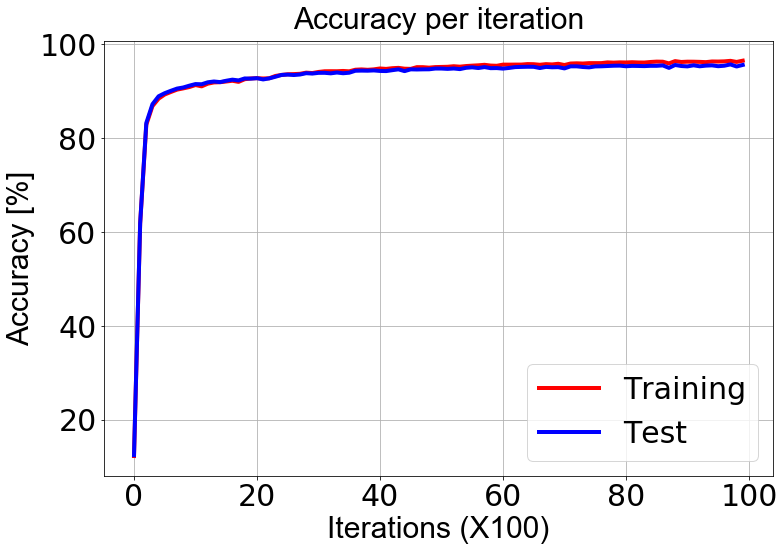

In [149]:
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
label_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal'}
plt.figure(figsize=(12,8))
plt.plot(Accuracy['Training_Accuracy'], 'r',lw=4,label='Training')
plt.plot(Accuracy['Test_Accuracy'], 'b',lw=4,label='Test')
plt.xlabel('Iterations (X100)',**label_font)
plt.ylabel('Accuracy [%]',**label_font)
plt.title('Accuracy per iteration',**title_font)
plt.legend(loc=4,prop={'size':30})
plt.grid()
plt.tick_params(axis='x',labelsize=30)
plt.tick_params(axis='y',labelsize=30)
plt.show()


In [140]:
# coding: utf-8

GSD_Accuracy = {'Training_Accuracy':[],'Test_Accuracy':[]}
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=530, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
print(train_size)
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
#    grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % 100 == 0:
        GSD_Accuracy['Training_Accuracy'].append(network.accuracy(x_train, t_train)*100)
        GSD_Accuracy['Test_Accuracy'].append(network.accuracy(x_test, t_test)*100)
        
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


60000
600.0
0.181016666667 0.1844
0.9083 0.9097
0.9345 0.9356
0.944216666667 0.9439
0.953633333333 0.9522
0.960283333333 0.9579
0.9667 0.9622
0.970966666667 0.9673
0.97385 0.9687
0.97745 0.9715
0.9788 0.973
0.980966666667 0.9725
0.983016666667 0.9747
0.984283333333 0.9752
0.9852 0.9752
0.98695 0.9775
0.987016666667 0.9784


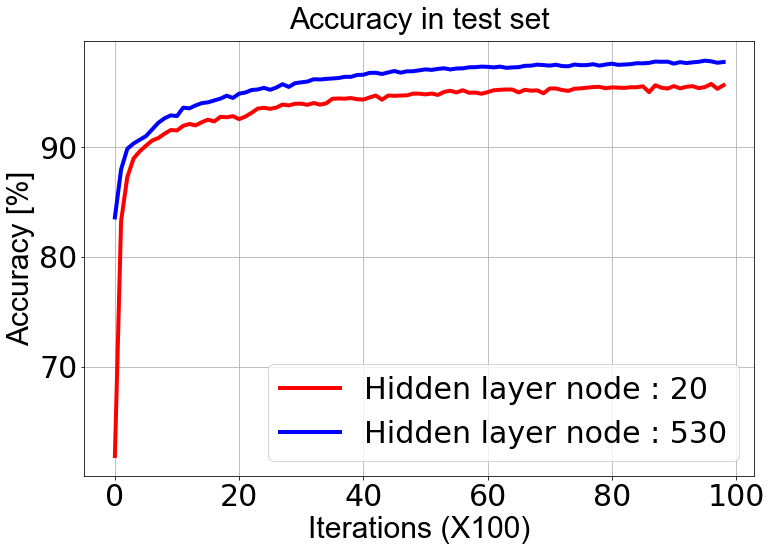

In [148]:
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
label_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal'}
BackAccu = list(Accuracy.values())
GSDAccu = list(GSD_Accuracy.values())
list1 = [i for i in range(99)]
plt.figure(figsize=(12,8))
plt.plot(list1,BackAccu[1][1:100], 'r',lw=4,label='Hidden layer node : 20')
plt.plot(list1,GSDAccu[1][1:100], 'b',lw=4,label='Hidden layer node : 530')
plt.xlabel('Iterations (X100)',**label_font)
plt.ylabel('Accuracy [%]',**label_font)
plt.title('Accuracy in test set',**title_font)
plt.legend(loc=4,prop={'size':30})
plt.grid()
plt.tick_params(axis='x',labelsize=30)
plt.tick_params(axis='y',labelsize=30)
plt.show()


In [135]:
BackAccu = list(Accuracy.values())
BackAccu[1][1:10]

[63.329999999999998,
 84.730000000000004,
 88.189999999999998,
 89.390000000000001,
 90.38000000000001,
 90.900000000000006,
 91.109999999999999,
 91.510000000000005,
 91.710000000000008]

In [123]:
list1 = [i for i in range(10)]

In [124]:
list1


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]